In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [190]:
df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/pow_inv-32-A_5min.pkl')
df_POA = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/poa_5min.pkl')
df_Tmod = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/tmod_5min.pkl')
df_met = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_T = df_met[['Temp','Timestamp']]
df_T = df_T.rename(columns={'Temp': 'Temp','Timestamp': 'time'})

df_inner = pd.merge(df_pow, df_POA, on='time', how='inner')
df_inner2 = pd.merge(df_inner, df_Tmod, on='time', how='inner')
df = pd.merge(df_inner2, df_T, on='time', how='inner')

df.set_index('time', inplace=True)
df = df.rename(columns={'power': 'Power','value_x': 'POA','value_y': 'Tmod' })

print(df.shape)
print(df.columns)

(113472, 4)
Index(['Power', 'POA', 'Tmod', 'Temp'], dtype='object')


In [191]:
# Define the morning hour range
start_hour = 6
end_hour = 21
# Filter rows based on morning hour range
df = df[(df.index.hour >= start_hour) & (df.index.hour < end_hour)]
print(df.shape)

(70920, 4)


In [192]:
df = df[df['POA']>0]
df = df[df['Power']>0]
print(df.shape)


(34341, 4)


In [193]:
# Solar panel = JKM345M-72-V x 5742 panels
POA_std = 1000
Capacity = 5742*345/1000000
T_std = 25 
#T_std = df['Tmod'].mean()
alpha = -0.004

'''
start_date = '2023-11-20'
end_date = '2023-11-22'

test = (df['Power'][start_date:end_date])/(Capacity*(1 + alpha*(df['Tmod'][start_date:end_date] - T_std))*df['POA'][start_date:end_date]/POA_std)
print(test)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
temp = test.dropna()
P_constant = np.mean(temp[temp>0])
P_constant = np.mean(temp)
print(P_constant)
'''


df['shifted_Power'] = df['Power'] 
df.loc['2023-04-02':'2023-09-30', 'shifted_Power'] = df.loc['2023-04-02':'2023-09-30', 'Power'].shift(periods=60, freq='T')


P_constant = 1.0
df['Power_calculated'] = P_constant*Capacity*(1 + alpha*(df['Tmod'] - T_std))*df['POA']/POA_std
df['Power_error'] = df['shifted_Power']/df['Power_calculated'] 

df = df[df['Power_error']<20]

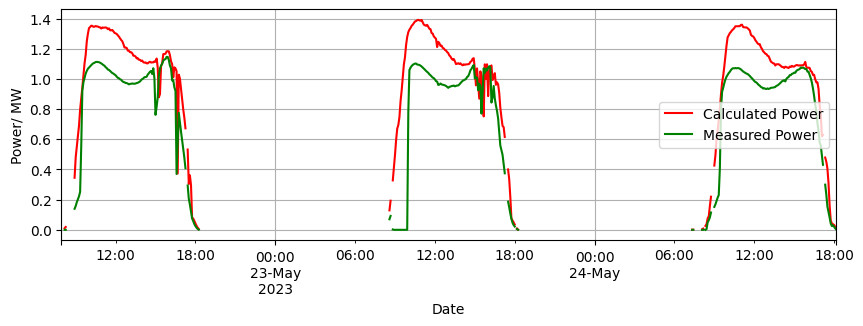

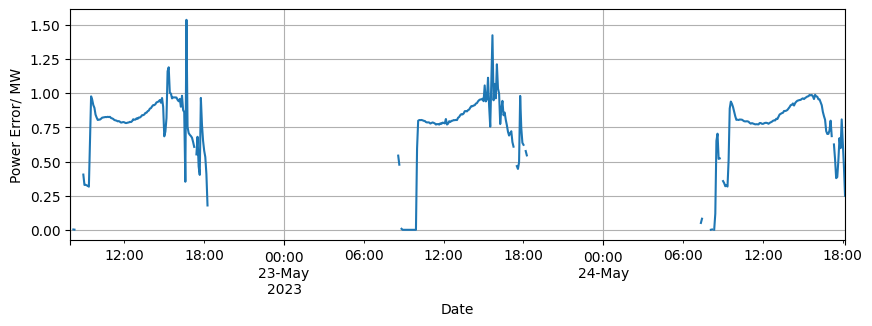

In [194]:
# Define the period you want to plot
start_date = '2023-05-22'
end_date = '2023-05-24'

#start_date = df.index.min()
#end_date = df.index.max()


# Slice the DataFrame based on the specified period
df_period = df[start_date:end_date]
df_shifted_period = df['shifted_Power'][start_date:end_date]
df_period['Power_calculated'].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Calculated Power')
df_period['shifted_Power'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Green'],label='Measured Power')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

#ax = df_period['Power'].resample('5min').mean().plot(figsize=(10, 3))
#plt.ylabel('Measured Power/ MW')
#plt.xlabel('Date')
#plt.grid(True)
#plt.show()

#ax = df_period['Power_calculated'].resample('5min').mean().plot(figsize=(10, 3))
#plt.ylabel('Calculated Power/ MW')
#plt.xlabel('Date')
#plt.grid(True)
#plt.show()

ax = df_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3))
plt.ylabel('Power Error/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [195]:
df.shape

(32166, 7)

In [196]:
df.describe()

,Power,POA,Tmod,Temp,shifted_Power,Power_calculated,Power_error
count,3.216600e+04,32166.000000,32166.000000,32166.000000,3.216600e+04,32166.000000,3.216600e+04
mean,7.155641e-01,522.836093,30.850672,21.236894,7.404705e-01,0.982685,7.874979e-01
std,5.640151e-01,359.660088,13.103039,34.659071,5.523064e-01,0.651771,5.464077e-01
min,1.819751e-11,0.488424,-5.910972,0.000000,1.819751e-11,0.000973,1.393645e-11
25%,1.477640e-01,173.599200,20.697370,14.400000,1.938984e-01,0.347446,5.942405e-01
50%,6.700347e-01,557.265000,29.854150,18.600000,7.132127e-01,1.079742,8.248342e-01
75%,1.239238e+00,815.031900,40.600590,24.200000,1.246225e+00,1.524652,9.061819e-01
max,1.700452e+00,1502.591000,68.853870,655.260000,1.700452e+00,2.787336,1.711394e+01


In [197]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Example: Generate synthetic time series data (replace with your own data loading)
np.random.seed(42)

# Define the period you want to plot
start_date = df.index.min()
end_date = df.index.max()

temp = df[start_date:end_date][['Power','Power_error']].resample('5min').mean()
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
print(temp.shape)
temp_cleaned = temp.dropna()
print(temp_cleaned.shape)
data = temp_cleaned.values
print(temp_cleaned.index)

True
False
(85687, 2)
(32166, 2)
DatetimeIndex(['2023-03-16 07:10:00', '2023-03-16 07:15:00',
               '2023-03-16 07:20:00', '2023-03-16 07:25:00',
               '2023-03-16 07:30:00', '2023-03-16 07:40:00',
               '2023-03-16 07:45:00', '2023-03-16 07:50:00',
               '2023-03-16 07:55:00', '2023-03-16 08:00:00',
               ...
               '2024-01-07 18:40:00', '2024-01-07 18:45:00',
               '2024-01-07 18:50:00', '2024-01-07 18:55:00',
               '2024-01-07 19:00:00', '2024-01-07 19:05:00',
               '2024-01-07 19:10:00', '2024-01-07 19:15:00',
               '2024-01-07 19:25:00', '2024-01-07 19:40:00'],
              dtype='datetime64[ns]', name='time', length=32166, freq=None)


In [198]:
# Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

In [199]:
# Create sequences/windows
'''
timesteps = 5 # Length of each sequence/window
num_sequences = len(data_normalized) - timesteps + 1

# Initialize an array to hold the sequences
sequences = np.zeros((num_sequences, timesteps, 1))

for i in range(num_sequences):
    sequences[i] = data_normalized[i:i + timesteps].reshape(-1, 1)

# Print the shape of the resulting three-dimensional array
print("Shape of the sequences array:", sequences.shape)
'''


# Create sequences for LSTM
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)


# Train-test split
#X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Define the split ratio
train_ratio = 1.0
test_ratio = 0.0
num_train_samples = int(train_ratio * len(data_normalized))

# Split the data
train_data = data_normalized[:num_train_samples]
test_data = data_normalized[num_train_samples:]

train_data_date = temp_cleaned.index[:num_train_samples]
test_data_date = temp_cleaned.index[num_train_samples:]


timesteps = 20  # Example sequence leng|th
train_sequences = create_sequences(train_data, timesteps)
test_sequences = create_sequences(test_data, timesteps)

print("Shape of the train sequences array:", train_sequences.shape)
print("Shape of the test sequences array:", test_sequences.shape)


Shape of the train sequences array: (32146, 20, 2)
Shape of the test sequences array: (0,)


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 lstm_16 (LSTM)              (None, 20, 64)               16896     ['input_5[0][0]']             
                                                                                                  
 lstm_17 (LSTM)              (None, 32)                   12416     ['lstm_16[0][0]']             
                                                                                                  
 dense_12 (Dense)            (None, 20)                   660       ['lstm_17[0][0]']             
                                                                                           

/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


503/503 [==============================] - 48s 96ms/step - loss: 13.1210
Epoch 6/200
503/503 [==============================] - 48s 96ms/step - loss: 12.7767
Epoch 7/200
503/503 [==============================] - 48s 96ms/step - loss: 12.2986
Epoch 8/200
503/503 [==============================] - 47s 94ms/step - loss: 11.8412
Epoch 9/200
503/503 [==============================] - 48s 96ms/step - loss: 11.5170
Epoch 10/200
494/503 [============================>.] - ETA: 0s - loss: 11.2836
Epoch 10: saving model to /home/ahilan/gen-research/neoen-site/models/test4/model_checkpoint_10.h5
503/503 [==============================] - 49s 97ms/step - loss: 11.2542
Epoch 11/200
503/503 [==============================] - 48s 96ms/step - loss: 11.0530
Epoch 12/200
503/503 [==============================] - 49s 97ms/step - loss: 10.9142
Epoch 13/200
503/503 [==============================] - 48s 96ms/step - loss: 10.7403
Epoch 14/200
503/503 [==============================] - 48s 95ms/step - loss:

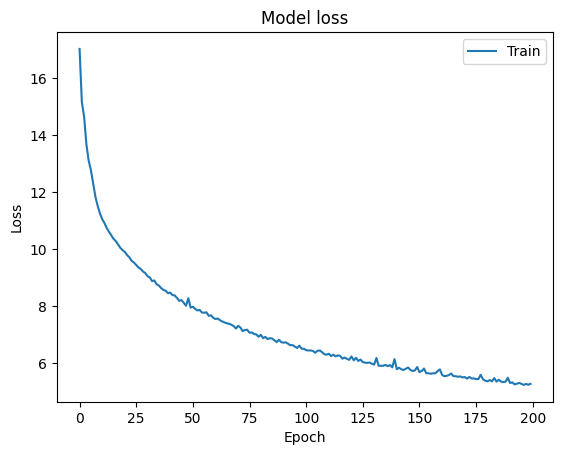

In [200]:
from tensorflow.keras.callbacks import EarlyStopping

# Function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Hyperparameters
input_dim = 1   
latent_dim = 20
dropout_rate = 0

# Encoder
inputs = Input(shape=(timesteps, input_dim))
h = LSTM(64, return_sequences=True,dropout=dropout_rate, recurrent_dropout=dropout_rate)(inputs)
h = LSTM(32)(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
#decoder_h1 = Dense(64)
decoder_repeat = RepeatVector(timesteps)
decoder_h2 = LSTM(32, return_sequences=True)
decoder_lstm = LSTM(64, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_output = TimeDistributed(Dense(input_dim))

#z = decoder_h1(z)
h_decoded = decoder_repeat(z)
h_decoded = decoder_h2(h_decoded)
x_decoded_mean = decoder_lstm(h_decoded)
x_decoded_mean = decoder_output(x_decoded_mean)



# VAE model
vae = Model(inputs, x_decoded_mean)

# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(x_decoded_mean))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.10*kl_loss)
vae.add_loss(vae_loss)

batch_size = 64

checkpoint_callback = ModelCheckpoint(
    filepath='/home/ahilan/gen-research/neoen-site/models/test4/model_checkpoint_{epoch:02d}.h5',  # Save with epoch and batch number in the filename
    save_weights_only=False,  # Set to True if you only want to save the model weights
    save_freq=5 * len(train_sequences) // batch_size,  # Change this to 'batch' to save after every batch
    verbose=1  # Set to 1 for verbose logging, 0 for silent
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=10, # Stop after 10 epochs of no improvement
    verbose=1
)

# Compile model
optimizer = Adam(learning_rate=1e-4)
vae.compile(optimizer=optimizer)
vae.summary()


# Train the VAE with early stopping
history = vae.fit(train_sequences[:,:,1], epochs=200, batch_size=64, callbacks=[checkpoint_callback])
#history = vae.fit(train_sequences[:,:,1], epochs=100, batch_size=64, validation_split=0.0, callbacks=[early_stopping_callback, checkpoint_callback])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')
plt.show()

## Plot training & validation loss values
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()

In [202]:
vae = tf.keras.models.load_model('/home/ahilan/gen-research/neoen-site/models/test4/model_checkpoint_200.h5')

1005/1005 [==============================] - 16s 13ms/step


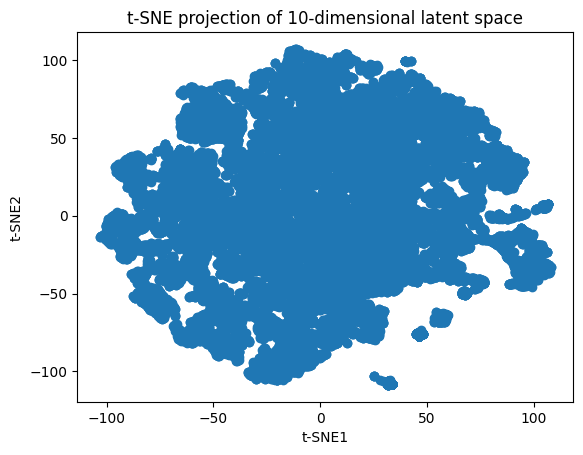

In [203]:
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(train_sequences[:,:,1])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(encoded_data)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE projection of 10-dimensional latent space')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()


## Encode and decode some data points
#encoder = Model(inputs, z_mean)
#encoded_data = encoder.predict(train_sequences)

# Display some of the encoded data
#plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
#plt.xlabel("Dimension 1")
#plt.ylabel("Dimension 2")
#plt.title("Encoded Data")
#plt.show()


/home/ahilan/kernels/default/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


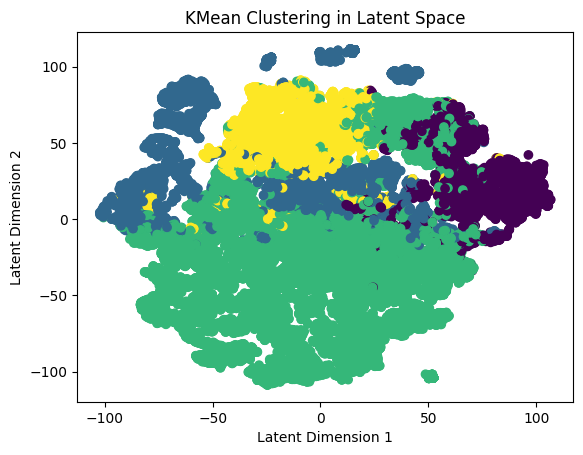

In [183]:
from sklearn.cluster import KMeans
#np.random.seed(42)
n_clusters=4
kmeans = KMeans(n_clusters, random_state=0).fit(encoded_data)
clusters = kmeans.labels_

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('KMean Clustering in Latent Space')
plt.show()



#from sklearn.mixture import GaussianMixture
# Fit GMM to the latent space
#gmm = GaussianMixture(n_components=4, random_state=0).fit(encoded_data)

# Assign cluster labels and get probabilities
#clusters = gmm.predict(encoded_data)
#probabilities = gmm.predict_proba(encoded_data)

# Visualize the clusters in the latent space (for 2D or 3D latent space)
#plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters)
#plt.xlabel('Latent Dimension 1')
#plt.ylabel('Latent Dimension 2')
#plt.title('GMM Clustering in Latent Space')
#plt.show()

In [184]:
reconstructed_sequences = vae.predict(train_sequences[:,:,1])

1005/1005 [==============================] - 25s 25ms/step


In [185]:
array_b = np.zeros((32146, 20, 1))
reconstructed_sequences_temp = np.concatenate([reconstructed_sequences,array_b], axis=-1) 
reconstructed_sequences_temp[:,:,1] = train_sequences[:,:,1]

(32166, 3)
(32166, 3)
                        Power  Power_error  Clusters
time                                                
2023-03-16 07:10:00  0.000039     0.038644       1.0
2023-03-16 07:15:00  0.000026     0.005935       1.0
2023-03-16 07:20:00  0.000029     0.002600       1.0
2023-03-16 07:25:00  0.000011     0.000448       1.0
2023-03-16 07:30:00  0.000082     0.001844       1.0
...                       ...          ...       ...
2024-01-07 19:05:00  0.715564     0.787498       0.0
2024-01-07 19:10:00  0.715564     0.787498       0.0
2024-01-07 19:15:00  0.715564     0.787498       0.0
2024-01-07 19:25:00  0.715564     0.787498       0.0
2024-01-07 19:40:00  0.715564     0.787498       0.0

[32166 rows x 3 columns]


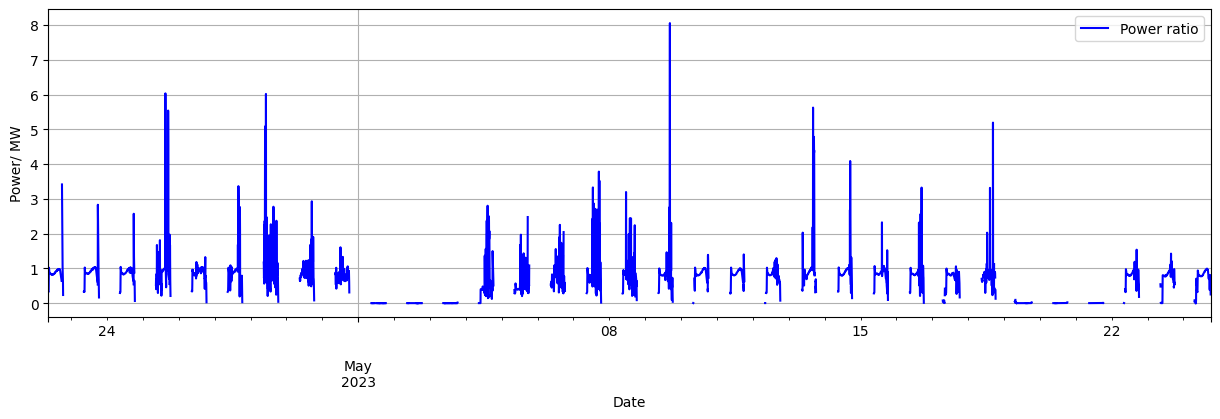

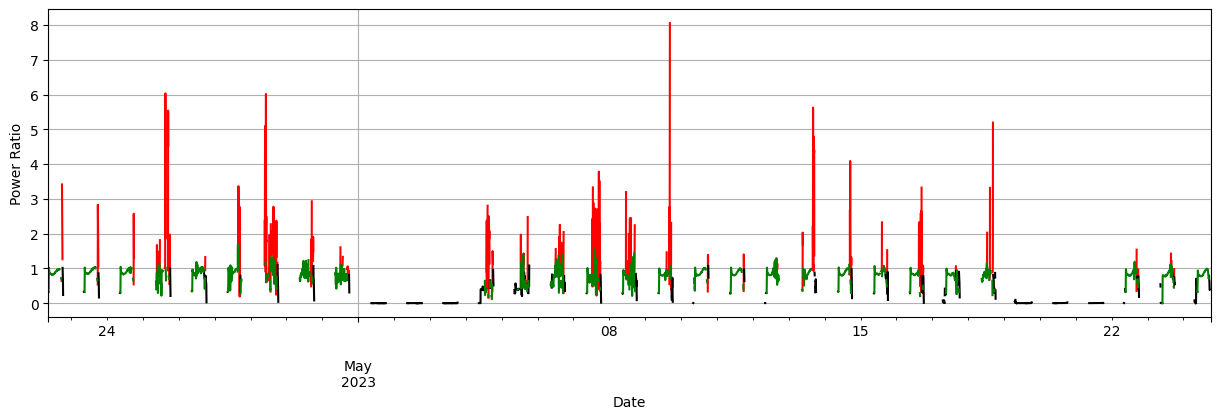

                        Power  Power_error  Clusters
time                                                
2023-03-16 07:10:00  0.000039     0.038644       1.0
2023-03-16 07:15:00  0.000026     0.005935       1.0
2023-03-16 07:20:00  0.000029     0.002600       1.0
2023-03-16 07:25:00  0.000011     0.000448       1.0
2023-03-16 07:30:00  0.000082     0.001844       1.0
...                       ...          ...       ...
2024-01-07 19:05:00  0.715564     0.787498       0.0
2024-01-07 19:10:00  0.715564     0.787498       0.0
2024-01-07 19:15:00  0.715564     0.787498       0.0
2024-01-07 19:25:00  0.715564     0.787498       0.0
2024-01-07 19:40:00  0.715564     0.787498       0.0

[32166 rows x 3 columns]


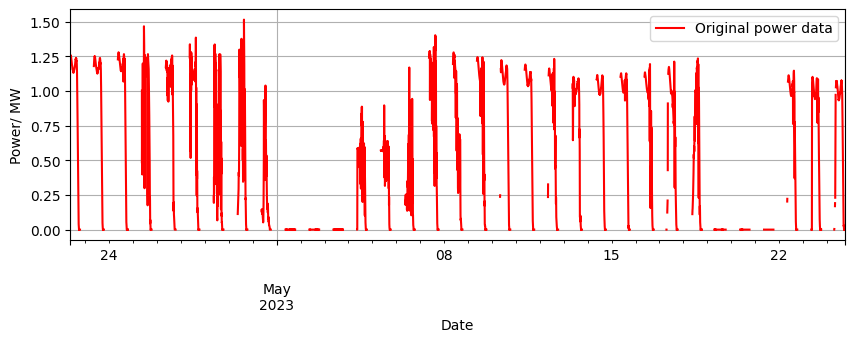

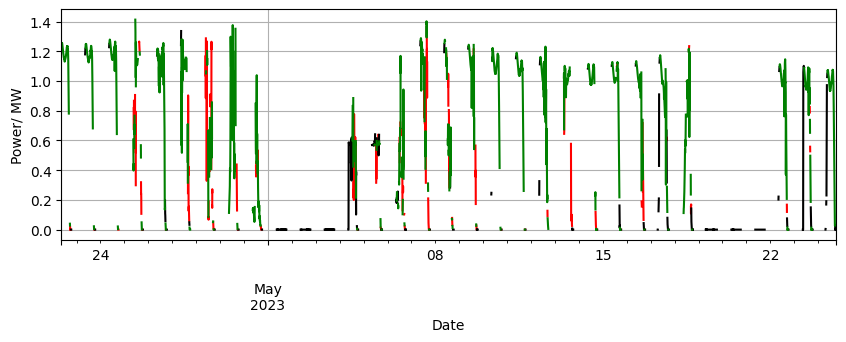

'\nprint(train_data.shape)\nplot_time_series_with_clusters(train_data[:,], cluster_ids, n_clusters)\n'

In [188]:
# Add cluster labels to the original sequences
clusters_temp = np.repeat(clusters[:, None, None], train_sequences.shape[1], axis=1)
original_sequences_with_clusters = np.concatenate([train_sequences, clusters_temp], axis=-1)
reconstructed_sequences_with_clusters = np.concatenate([reconstructed_sequences_temp, clusters_temp], axis=-1)


# Initialize an array to hold cluster IDs for the entire time series
cluster_ids = np.full(len(train_data), -1)

# Map each sequence's cluster ID back to the corresponding indices in the original time series
for i in range(len(train_sequences)):
    cluster_ids[i:i+timesteps] = clusters[i]

# Handle the overlapping indices by assigning the most frequent cluster ID
for i in range(timesteps):
    unique, counts = np.unique(cluster_ids[i:i+timesteps], return_counts=True)
    most_frequent_cluster = unique[np.argmax(counts)]
    cluster_ids[i:i+timesteps] = most_frequent_cluster

# Ensure the cluster_ids array has the same length as the original time series
cluster_ids = cluster_ids[:len(train_data)]

def plot_time_series_with_clusters(data, cluster_ids, n_clusters):
    plt.figure(figsize=(15, 8))
    for cluster_id in range(n_clusters):
        plt.plot(data[cluster_ids == cluster_id], label=f'Cluster {cluster_id}')
    plt.xlabel('Time')
    plt.ylabel('Normalized Value')
    plt.title('Time Series with Cluster IDs')
    plt.legend()
    plt.show()



# 1. Reshape sequences back to original form
original_shape = (len(train_data), 3)
reconstructed_shape = (len(train_data), 3)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(reconstructed_shape)

for i in range(len(train_sequences) - timesteps):
    reconstructed_original_data[i:i + timesteps] = original_sequences_with_clusters[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences_with_clusters[i]


reconstructed_original_data[:,0:2] = scaler.inverse_transform(reconstructed_original_data[:,0:2])
reconstructed_vae_data[:,0:2] = scaler.inverse_transform(reconstructed_vae_data[:,0:2])


df_orginal = pd.DataFrame(data = reconstructed_original_data, index = train_data_date, columns = ['Power','Power_error','Clusters'])
df_vae_output = pd.DataFrame(data = reconstructed_vae_data, index = train_data_date, columns = ['Power_error','Power','Clusters'])

print(df_orginal.shape)
print(df_vae_output.shape)

start_date = '2023-04-22'
end_date = '2023-05-24'

print(df_orginal)
df_orginal['Power_error'][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'],label='Power ratio')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

df_orginal['Power_error'][df_orginal['Clusters']==0][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Red'])
df_orginal['Power_error'][df_orginal['Clusters']==1][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Black'])
df_orginal['Power_error'][df_orginal['Clusters']==2][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Green'])
#df_orginal['Power_error'][df_orginal['Clusters']==3][start_date:end_date].resample('5min').mean().plot(figsize=(15, 4), color =['Blue'])
plt.ylabel('Power Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.show()

print(df_orginal)
df_orginal['Power'][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original power data')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

df_orginal['Power'][df_orginal['Clusters']==0][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'])
df_orginal['Power'][df_orginal['Clusters']==1][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Black'])
df_orginal['Power'][df_orginal['Clusters']==2][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Green'])
#df_orginal['Power'][df_orginal['Clusters']==3][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Blue'])
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()


#df_vae_output['Power_error'][df_vae_output['Clusters']==0][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Blue'])
#df_vae_output['Power_error'][df_vae_output['Clusters']==1][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Red'])
#df_vae_output['Power_error'][df_vae_output['Clusters']==2][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Green'])
#df_vae_output['Power_error'][df_vae_output['Clusters']==3][start_date:end_date].resample('5min').mean().plot(figsize=(10, 3), color =['Black'])
#plt.ylabel('Power/ MW')
#plt.xlabel('Date')
#plt.grid(True)
#plt.show()


'''
print(train_data.shape)
plot_time_series_with_clusters(train_data[:,], cluster_ids, n_clusters)
'''

In [588]:
data = train_data
data_sequences = train_sequences
date_index = train_data_date

reconstructed_sequences = vae.predict(data_sequences)

# 1. Reshape sequences back to original form
original_shape = (len(data), 1)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)

for i in range(len(data_sequences) - timesteps):
    reconstructed_original_data[i:i + timesteps] = data_sequences[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences[i]


X_test_original = scaler.inverse_transform(reconstructed_original_data)
X_test_vae = scaler.inverse_transform(reconstructed_vae_data)

df_orginal = pd.DataFrame(data = X_test_original, index = date_index, columns = ['Power_error'])
df_vae_output = pd.DataFrame(data = X_test_vae, index = date_index, columns = ['Power_error'])


1005/1005 [==============================] - 64s 62ms/step


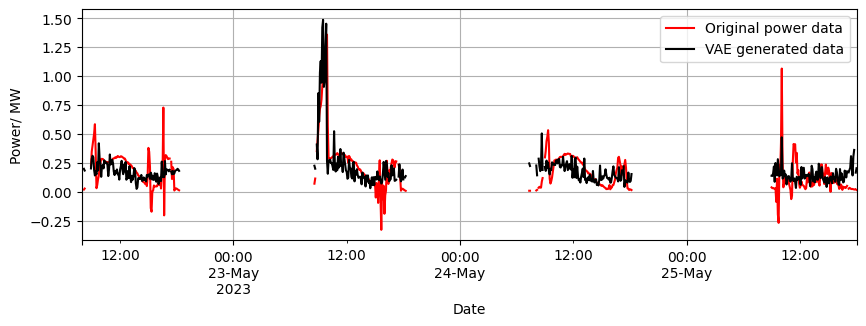

"\ndf_period['POA'].resample('H').mean().plot(figsize=(5, 4))\nplt.ylabel('POA/ WM$^{-2}$')\nplt.xlabel('Date')\nplt.grid(True)\nplt.show()\n\ndf_period['Power'].resample('H').mean().plot(figsize=(5, 4))\nplt.ylabel('Power/ MW')\nplt.xlabel('Date')\nplt.grid(True)\nplt.show()\n"

In [590]:
# Define the period you want to plot
start_date = '2023-05-22'
end_date = '2023-05-25'

# Slice the DataFrame based on the specified period
df_orginal_period = df_orginal[start_date:end_date]
df_vae_output_period = df_vae_output[start_date:end_date]


df_orginal_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3), color =['Red'],label='Original power data')
df_vae_output_period['Power_error'].resample('5min').mean().plot(figsize=(10, 3),color =['Black'],label='VAE generated data')
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()



'''
df_period['POA'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('POA/ WM$^{-2}$')
plt.xlabel('Date')
plt.grid(True)
plt.show()

df_period['Power'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()
'''